In [5]:
from collections import defaultdict
from copy import deepcopy
import pandas
import numpy
from utils import get_user_data_general, get_folders, parallel_style_w_one_arg
from astropy.io import fits
from sklearn.decomposition import PCA
from umap import UMAP
from seaborn import pairplot
import hiplot
from matplotlib import pyplot
from panel import widgets, extension, depends, Column, Row, Tabs
extension()
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
THRESHOLD = 0

In [7]:
NAME_DB, PATH_FOLDERS, DIRECTORIES, PERCENTAGE_TRAIN, NORMA = get_user_data_general()
FOLDERS = get_folders(PATH_FOLDERS, NAME_DB, DIRECTORIES)
FOLDER_DATABASE = FOLDERS[0]

path_image_files = sorted(FOLDER_DATABASE.glob("*.fits"))
path_labels_files = sorted(FOLDER_DATABASE.glob("*.npy"))
raw_images_data = parallel_style_w_one_arg(func=lambda arg: fits.getdata(arg), data=path_image_files)
labels_data = parallel_style_w_one_arg(func=lambda arg: numpy.load(arg), data=path_labels_files)

if THRESHOLD > 0:
    unique_random_integers = numpy.random.choice(numpy.arange(raw_images_data.shape[0]), THRESHOLD, replace=False)
    temp_images = raw_images_data[unique_random_integers]
    temp_labels = labels_data[unique_random_integers]
    raw_images_data = temp_images
    labels_data = temp_labels
    del temp_images, temp_labels

print(numpy.isnan(raw_images_data).all() == False, numpy.isnan(labels_data).all() == False)
print("NOMBRE de CLEAR :", numpy.sum(labels_data == 0))
print("NOMBRE de CLOUDY :", numpy.sum(labels_data == 1))

temp_database = deepcopy(raw_images_data)
reshaped_database = numpy.reshape(temp_database, (numpy.shape(temp_database)[0], -1)) 
del temp_database

Timeout while searching in /home, moving to next directory.
loading images with 32 cpus
loading images with 32 cpus
True True
NOMBRE de CLEAR : 1400
NOMBRE de CLOUDY : 1400


In [8]:
NB_PRINC_CPNTS = 2

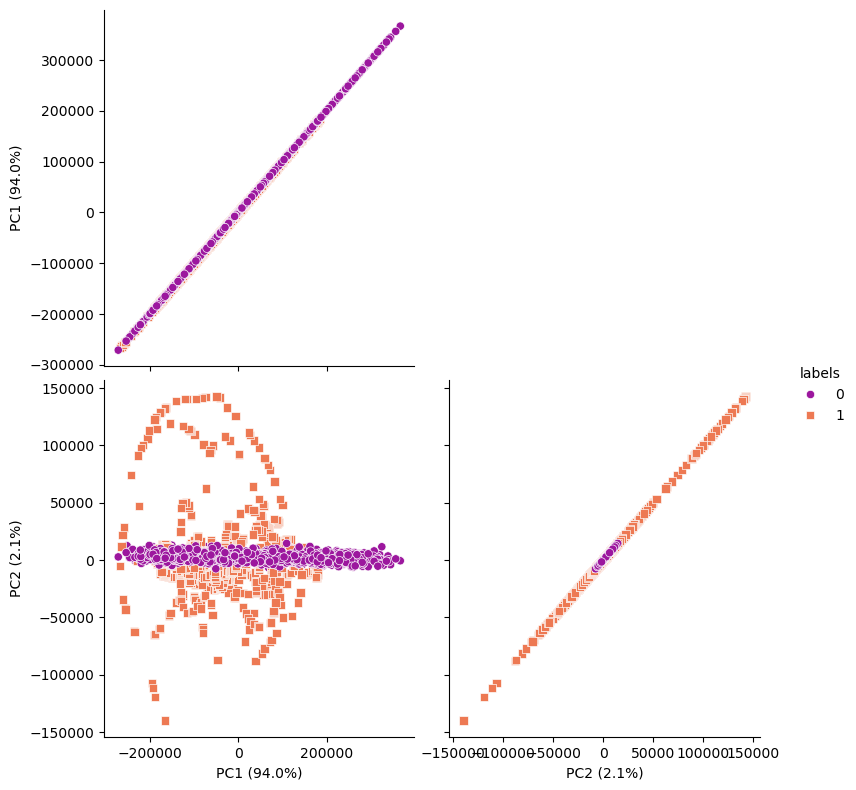

In [9]:
column_labels = pandas.DataFrame({'labels':(labels_data.reshape(labels_data.shape[0]))})
PCA_total = PCA(n_components=NB_PRINC_CPNTS, svd_solver='auto')
embedding = PCA_total.fit_transform( reshaped_database )
explained_variance_ratio = PCA_total.explained_variance_ratio_ * 100
dimensions = [f"PC{i+1} ({var:.1f}%)" for i, var in enumerate(PCA_total.explained_variance_ratio_ * 100)]
dataframe_embedding = pandas.DataFrame(embedding, columns=dimensions)
reduced_database_concatenation = pandas.concat((dataframe_embedding, column_labels), axis=1)
pairplot(reduced_database_concatenation, hue='labels', palette='plasma', diag_kind=None, height=4, corner=True, markers=["o", "s"])

In [ ]:
def load_metrics(arg):
    return (
        numpy.mean(arg),
        numpy.median(arg),
        numpy.linalg.norm(arg, ord=numpy.inf),
        # numpy.linalg.norm(arg, ord=1),
        # numpy.linalg.norm(arg, ord='fro'),
    )
results = parallel_style_w_one_arg(func=load_metrics, data=raw_images_data)

measures_norms = defaultdict(list)
for result in results:
    measures_norms['mean'].append(result[0])
    measures_norms['median'].append(result[1])
    measures_norms['inf'].append(result[2])
    # measures_norms['l1'].append(result[2])
    # measures_norms['fro'].append(result[4])

dataframe_norms = pandas.DataFrame(measures_norms)
print(f"\n OUTPUTS metrics: {list(dataframe_norms.keys())}")
concatenated = pandas.concat((column_labels, dataframe_norms.iloc[:, :]), axis=1)
hiplot.Experiment.from_dataframe(concatenated).display(force_full_width=True)

In [4]:
def create_umap_plot(reshaped_db, labels_db):
    
    nb_neighbors_input = widgets.IntInput(name='Number of Neighbors', value=30, step=1)
    bool_selector_state = widgets.Select(name='New random State', options=['Yes', 'No'], value='No')
    bool_selector_class = widgets.Select(name='Precise 2 classes for Umap', options=['Yes', 'No'], value='Yes')
    random_state_slider = widgets.IntSlider(name='Seed', start=0, end=100, value=13)

    @depends(
        nb_neighbors=nb_neighbors_input,
        bool_rd=bool_selector_state,
        bool_class=bool_selector_class,
        seed=random_state_slider
    )
    def update_plot(nb_neighbors, bool_rd, bool_class, seed):

        if bool_rd =="No":
            seed=13

        embedding = UMAP(n_neighbors=nb_neighbors, n_components=2, init='pca', random_state=seed, learning_rate=0.9)
        if bool_class =="No":
            umap_results = embedding.fit_transform(reshaped_db)
        else:
            umap_results = embedding.fit_transform(X=reshaped_db, y=labels_db)

        fig, ax = pyplot.subplots(1, figsize=(10, 6))
        points_label0 = umap_results[labels_db == 0]
        points_label1 = umap_results[labels_db == 1]
        ax.scatter(*points_label0.T, s=10, c='blue', alpha=1.0, label='Clear')
        ax.scatter(*points_label1.T, s=10, c='red', alpha=1.0, label='Clound')
        ax.legend()
        pyplot.title('UMAP')
        pyplot.close()

        return fig

    return Column(
        Row(nb_neighbors_input),
        Row(bool_selector_state, random_state_slider),
        Row(bool_selector_class),
        update_plot
    )

Tabs( ('UMAP plot', create_umap_plot(reshaped_database, labels_data)) )

BokehModel(combine_events=True, render_bundle={'docs_json': {'f6cafa04-1e87-4b05-896b-0b1e0be8e3c3': {'version…